In [1]:
# Import base libraries
import pandas as pd
import numpy as np

In [2]:
# Import forecasting tools
from statsmodels.tsa.ar_model import AR,ARResults

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Dataset
Consumer Price Index: All Items for Turkey

Frequency:  Monthly

Units:  Index 2015=100, Not Seasonally Adjusted

Source: https://fred.stlouisfed.org/series/TURCPIALLMINMEI








In [44]:
# Load data
from google.colab import files
uploaded = files.upload()

Saving TURCPIALLMINMEI.csv to TURCPIALLMINMEI.csv


In [45]:
import io
df = pd.read_csv(io.BytesIO(uploaded["TURCPIALLMINMEI.csv"]),index_col="DATE",parse_dates=True)

In [46]:
df.head()

,TURCPIALLMINMEI
DATE,
1960-01-01,0.000038
1960-02-01,0.000038
1960-03-01,0.000038
1960-04-01,0.000038
1960-05-01,0.000037


In [47]:
# Change the column name 
df.columns = ["CPI_TR"]

In [48]:
df.index

DatetimeIndex(['1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01',
               '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01',
               '1960-09-01', '1960-10-01',
               ...
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01'],
              dtype='datetime64[ns]', name='DATE', length=726, freq=None)

In [49]:
# Set the frequency
df.index.freq = "MS"

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 726 entries, 1960-01-01 to 2020-06-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CPI_TR  726 non-null    float64
dtypes: float64(1)
memory usage: 11.3 KB


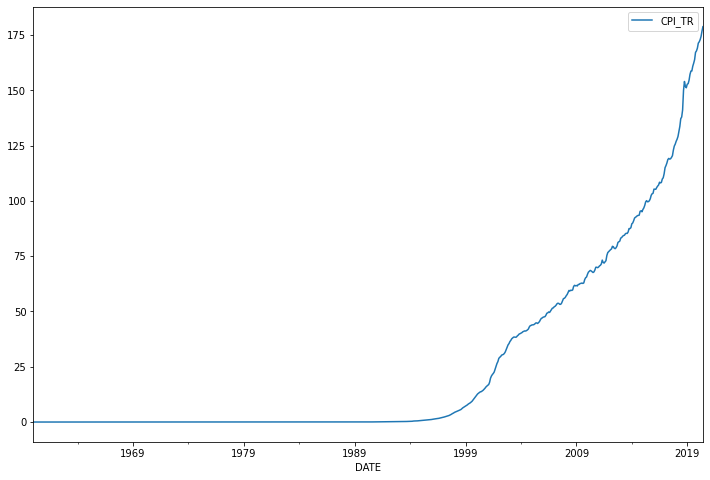

In [51]:
# Plotting
df.plot(figsize=(12,8));

In [52]:
# Firstly we need check stationarity
# To determine whether a series is stationary we can use the augmented Dickey-Fuller Test.
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=""):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f"Augmented Dickey-Fuller Test: {title}")
    result = adfuller(series.dropna(),autolag="AIC") # .dropna() handles differenced data
    
    labels = ["ADF test statistic","p-value","# lags used","# observations"]
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f"critical value ({key})"]=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [53]:
# ADF test
adf_test(df["CPI_TR"],"Consumer Price Index: Turkey")

Augmented Dickey-Fuller Test: Consumer Price Index: Turkey
ADF test statistic        2.781453
p-value                   1.000000
# lags used              20.000000
# observations          705.000000
critical value (1%)      -3.439660
critical value (5%)      -2.865648
critical value (10%)     -2.568958
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


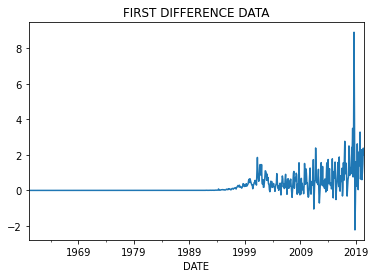

In [54]:
# Series is nonstationary, that's why we need to apply differencing.
from statsmodels.tsa.statespace.tools import diff
df["Diff_CPI"] = diff(df["CPI_TR"],k_diff=1)

df["Diff_CPI"].plot(title="FIRST DIFFERENCE DATA").autoscale(axis="x",tight=True);

In [55]:
# Recheck stationarity
adf_test(df["Diff_CPI"],"I(1)- CPI_TR ")

Augmented Dickey-Fuller Test: I(1)- CPI_TR 
ADF test statistic        0.074576
p-value                   0.964282
# lags used              19.000000
# observations          705.000000
critical value (1%)      -3.439660
critical value (5%)      -2.865648
critical value (10%)     -2.568958
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


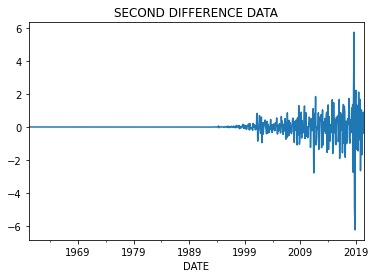

In [56]:
# After the first order of integration, series is yet not stationary.
# Let's apply I(2)
df["Diff(2)_CPI"] = diff(df["Diff_CPI"],k_diff=1)

df["Diff(2)_CPI"].plot(title="SECOND DIFFERENCE DATA").autoscale(axis="x",tight=True);

In [58]:
# After implementing of I(2) series is stationary
adf_test(df["Diff(2)_CPI"],"I(2)- CPI_TR")

Augmented Dickey-Fuller Test: I(2)- CPI_TR
ADF test statistic     -7.865644e+00
p-value                 5.143588e-12
# lags used             2.000000e+01
# observations          7.030000e+02
critical value (1%)    -3.439686e+00
critical value (5%)    -2.865660e+00
critical value (10%)   -2.568964e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


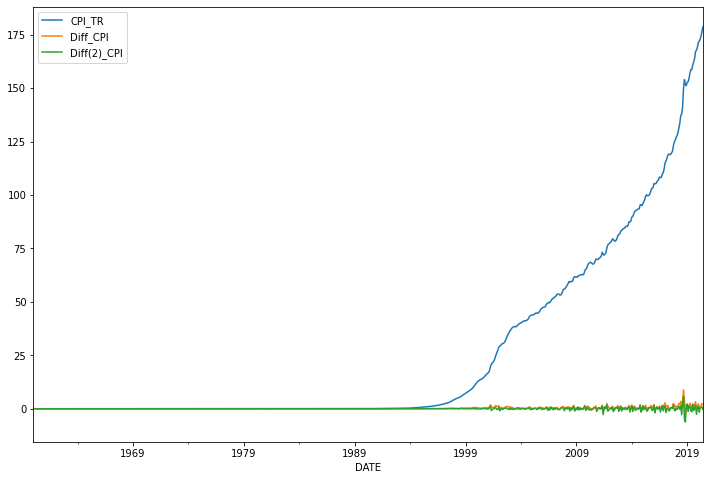

In [59]:
df.plot(figsize=(12,8));

In [60]:
df.columns

Index(['CPI_TR', 'Diff_CPI', 'Diff(2)_CPI'], dtype='object')

In [61]:
# Drop columns
df.drop(["CPI_TR", "Diff_CPI"],1,inplace=True)

In [68]:
# Time series preprocessing
# Fill nan values with 0
df.fillna(0,inplace=True)

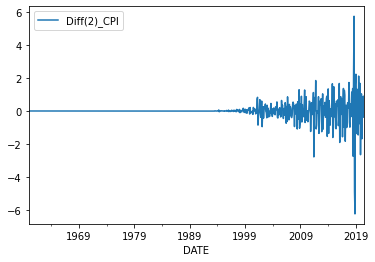

In [69]:
df.plot();

In [70]:
# Train and Test split
len(df["Diff(2)_CPI"])

726

In [71]:
train = df.iloc[:600]
test = df.iloc[600:]

In [72]:
len(test)

126

In [73]:
# Let's fit AR(1) model
model = AR(train)

In [74]:
# maxlag = order of Autoregression model
AR1fit = model.fit(maxlag=1)

In [75]:
print(f"Lag: {AR1fit.k_ar}")
print(f"Coefficients:\n{AR1fit.params}")

Lag: 1
Coefficients:
const             0.000892
L1.Diff(2)_CPI   -0.230826
dtype: float64


In [76]:
# format for obtaining predictions
start=len(train)
end=len(train)+len(test)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename("AR(1) Predictions")

In [77]:
# Prediction
predictions1 = AR1fit.predict(start=start,end=end, dynamic=False)

In [78]:
predictions1 = predictions1.rename("AR(1) Predictions")

In [79]:
predictions1

2010-01-01    0.109845
2010-02-01   -0.024463
2010-03-01    0.006538
2010-04-01   -0.000618
2010-05-01    0.001034
                ...   
2020-02-01    0.000724
2020-03-01    0.000724
2020-04-01    0.000724
2020-05-01    0.000724
2020-06-01    0.000724
Freq: MS, Name: AR(1) Predictions, Length: 126, dtype: float64

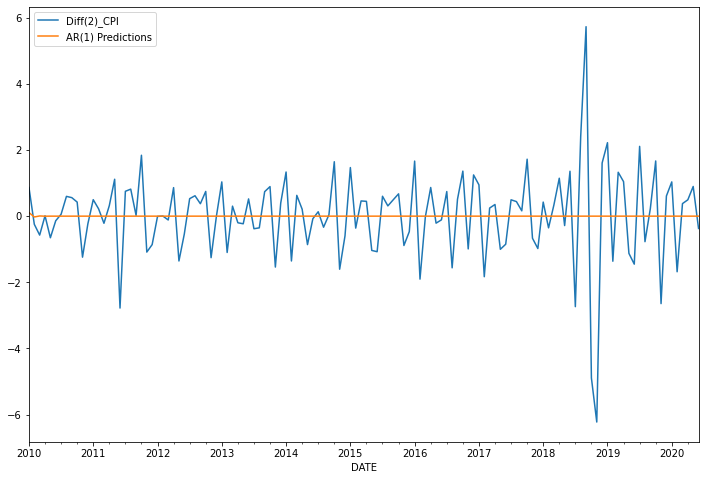

In [80]:
test.plot(figsize=(12,8),legend=True)
predictions1.plot(legend =True);

In [81]:
# Let's try AR(2)
# Two time steps lagging in order to predict the next time step 
AR2fit = model.fit(maxlag=2)

In [82]:
# Check AR(2) model details
print(f"Lag: {AR2fit.k_ar}")
print(f"Coefficients:\n{AR2fit.params}")

Lag: 2
Coefficients:
const             0.001557
L1.Diff(2)_CPI   -0.287601
L2.Diff(2)_CPI   -0.231348
dtype: float64


In [83]:
# Prediction AR(2)
predictions2 = AR2fit.predict(start=start,end=end, dynamic=False).rename("AR(2) Predictions")

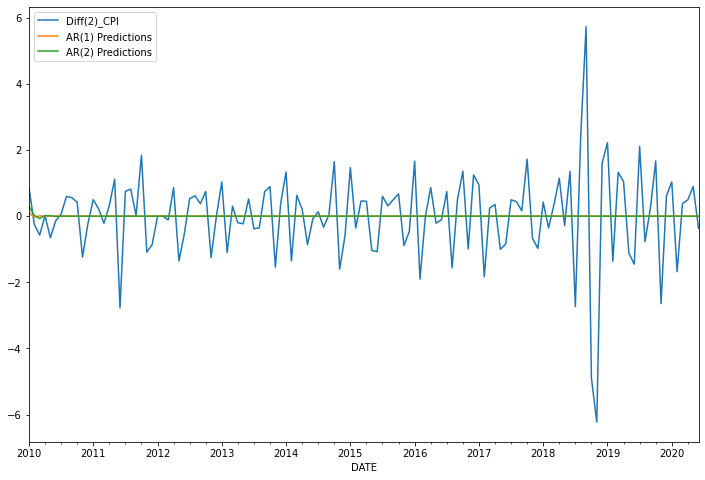

In [84]:
# Plotting
test.plot(figsize=(12,8),legend=True)
predictions1.plot(legend = True)
predictions2.plot(legend= True);

In [85]:
# We can actually lets statsmodels choose that P for us
# This time we'll omit the maxlag argument
# aic = Akaike information criterion
ARfit = model.fit(ic="aic")

In [87]:
# Check model details
# So based on our information criteria statsmodels decided that it should have 15 lags or order 15.
print(f"Lag: {ARfit.k_ar}")
print(f"Coefficients:\n{ARfit.params}")

Lag: 15
Coefficients:
const              0.003277
L1.Diff(2)_CPI    -0.553018
L2.Diff(2)_CPI    -0.367087
L3.Diff(2)_CPI    -0.376719
L4.Diff(2)_CPI    -0.506724
L5.Diff(2)_CPI    -0.290287
L6.Diff(2)_CPI    -0.175535
L7.Diff(2)_CPI    -0.338858
L8.Diff(2)_CPI    -0.252274
L9.Diff(2)_CPI    -0.184152
L10.Diff(2)_CPI   -0.364437
L11.Diff(2)_CPI   -0.328944
L12.Diff(2)_CPI    0.159702
L13.Diff(2)_CPI    0.102548
L14.Diff(2)_CPI   -0.137059
L15.Diff(2)_CPI   -0.232833
dtype: float64


In [90]:
# Prediction AR(15)
predictions15 = ARfit.predict(start=start,end=end, dynamic=False).rename("AR(15) Predictions")

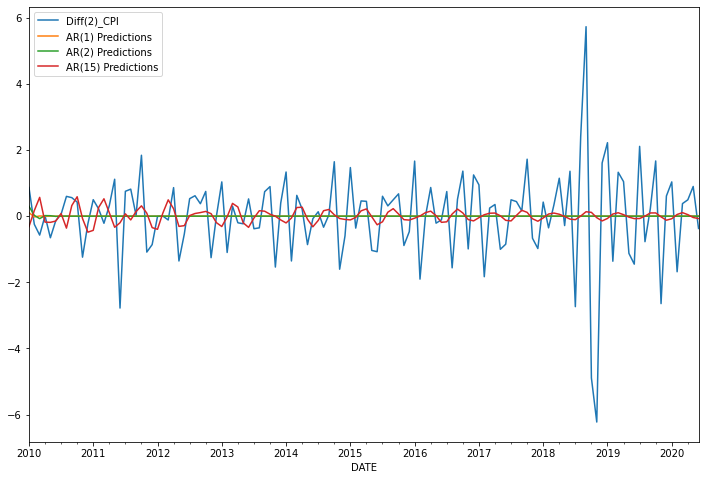

In [91]:
# Plotting
test.plot(figsize=(12,8),legend=True)
predictions1.plot(legend = True)
predictions2.plot(legend= True)
predictions15.plot(legend=True);

In [105]:
# Let's try AR(30)
ARfit30 = model.fit(maxlag=30)

In [107]:
# Check model details
print(f"Lag: {ARfit30.k_ar}")
print(f"Coefficients:\n{ARfit30.params}")

Lag: 30
Coefficients:
const              0.002337
L1.Diff(2)_CPI    -0.560939
L2.Diff(2)_CPI    -0.371721
L3.Diff(2)_CPI    -0.377721
L4.Diff(2)_CPI    -0.468698
L5.Diff(2)_CPI    -0.248062
L6.Diff(2)_CPI    -0.215496
L7.Diff(2)_CPI    -0.361458
L8.Diff(2)_CPI    -0.272459
L9.Diff(2)_CPI    -0.155581
L10.Diff(2)_CPI   -0.317945
L11.Diff(2)_CPI   -0.320102
L12.Diff(2)_CPI    0.054247
L13.Diff(2)_CPI    0.061407
L14.Diff(2)_CPI   -0.147035
L15.Diff(2)_CPI   -0.236144
L16.Diff(2)_CPI    0.027065
L17.Diff(2)_CPI    0.012427
L18.Diff(2)_CPI   -0.021235
L19.Diff(2)_CPI    0.004502
L20.Diff(2)_CPI    0.055463
L21.Diff(2)_CPI    0.052712
L22.Diff(2)_CPI   -0.041199
L23.Diff(2)_CPI    0.110672
L24.Diff(2)_CPI    0.353622
L25.Diff(2)_CPI    0.243137
L26.Diff(2)_CPI    0.117621
L27.Diff(2)_CPI    0.101073
L28.Diff(2)_CPI    0.058860
L29.Diff(2)_CPI   -0.127378
L30.Diff(2)_CPI    0.181959
dtype: float64


In [109]:
# Prediction AR(30)
predictions30 = ARfit30.predict(start=start,end=end, dynamic=False).rename("AR(30) Predictions")

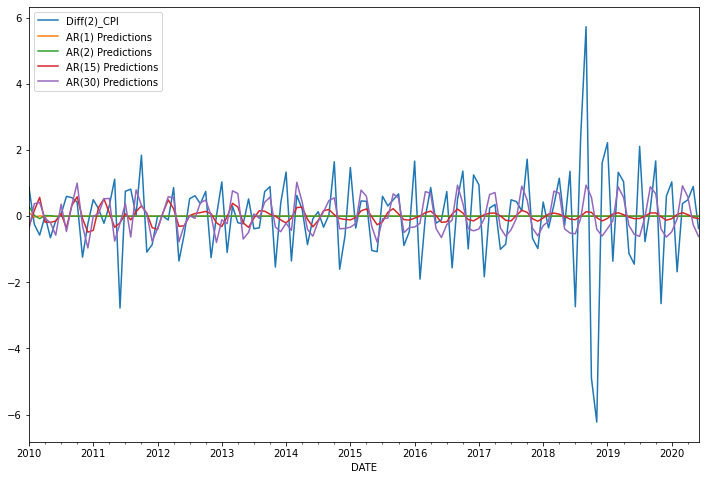

In [110]:
# Plotting
test.plot(figsize=(12,8),legend=True)
predictions1.plot(legend = True)
predictions2.plot(legend= True)
predictions15.plot(legend=True)
predictions30.plot(legend=True);

In [111]:
# Let's try the last AR(50) model
ARfit50 = model.fit(maxlag=50)

In [112]:
# Check model details
print(f"Lag: {ARfit50.k_ar}")
print(f"Coefficients:\n{ARfit50.params}")

Lag: 50
Coefficients:
const              0.003527
L1.Diff(2)_CPI    -0.526224
L2.Diff(2)_CPI    -0.361753
L3.Diff(2)_CPI    -0.367280
L4.Diff(2)_CPI    -0.397037
L5.Diff(2)_CPI    -0.257705
L6.Diff(2)_CPI    -0.181310
L7.Diff(2)_CPI    -0.315977
L8.Diff(2)_CPI    -0.257129
L9.Diff(2)_CPI    -0.040797
L10.Diff(2)_CPI   -0.285789
L11.Diff(2)_CPI   -0.226648
L12.Diff(2)_CPI    0.028887
L13.Diff(2)_CPI   -0.013799
L14.Diff(2)_CPI   -0.178039
L15.Diff(2)_CPI   -0.188343
L16.Diff(2)_CPI    0.045401
L17.Diff(2)_CPI    0.013377
L18.Diff(2)_CPI   -0.010802
L19.Diff(2)_CPI    0.036020
L20.Diff(2)_CPI    0.002626
L21.Diff(2)_CPI    0.042876
L22.Diff(2)_CPI    0.002368
L23.Diff(2)_CPI    0.133899
L24.Diff(2)_CPI    0.217957
L25.Diff(2)_CPI    0.093694
L26.Diff(2)_CPI    0.052106
L27.Diff(2)_CPI   -0.028385
L28.Diff(2)_CPI   -0.125646
L29.Diff(2)_CPI   -0.209431
L30.Diff(2)_CPI    0.095252
L31.Diff(2)_CPI   -0.291921
L32.Diff(2)_CPI   -0.184715
L33.Diff(2)_CPI   -0.184695
L34.Diff(2)_CPI   -0.17103

In [113]:
# Prediction AR(50)
predictions50 = ARfit50.predict(start=start,end=end, dynamic=False).rename("AR(50) Predictions")

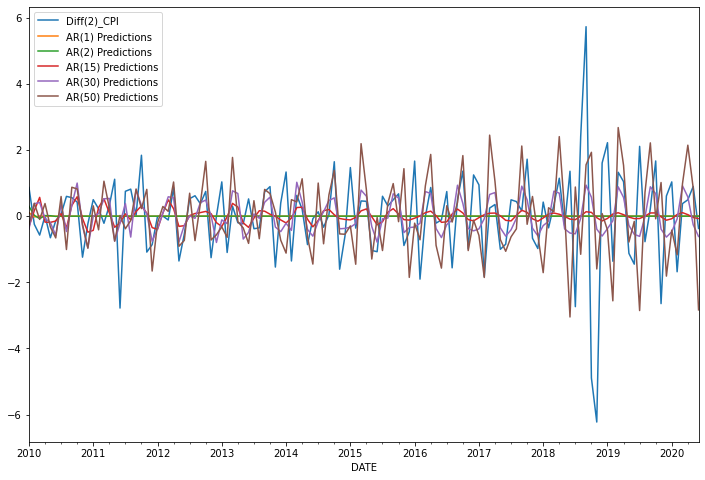

In [114]:
# Plotting
test.plot(figsize=(12,8),legend=True)
predictions1.plot(legend = True)
predictions2.plot(legend= True)
predictions15.plot(legend=True)
predictions30.plot(legend=True)
predictions50.plot(legend=True);

In [115]:
# Let's evaluate models
from sklearn.metrics import mean_squared_error

In [116]:
labels = ["AR1","AR2","AR15","AR30","AR50"]

In [117]:
preds = [predictions1,predictions2,predictions15,predictions30,predictions50]

In [120]:
# RMSE
# AR(30) outperformed the other four models
for i in range(5):
  error = np.sqrt(mean_squared_error(test["Diff(2)_CPI"],preds[i]))
  print(f"{labels[i]} RMSE: {error}")

AR1 RMSE: 1.3350535525996063
AR2 RMSE: 1.3341577276973242
AR15 RMSE: 1.3328571594628726
AR30 RMSE: 1.2941918562427854
AR50 RMSE: 1.6149606273960713
